# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

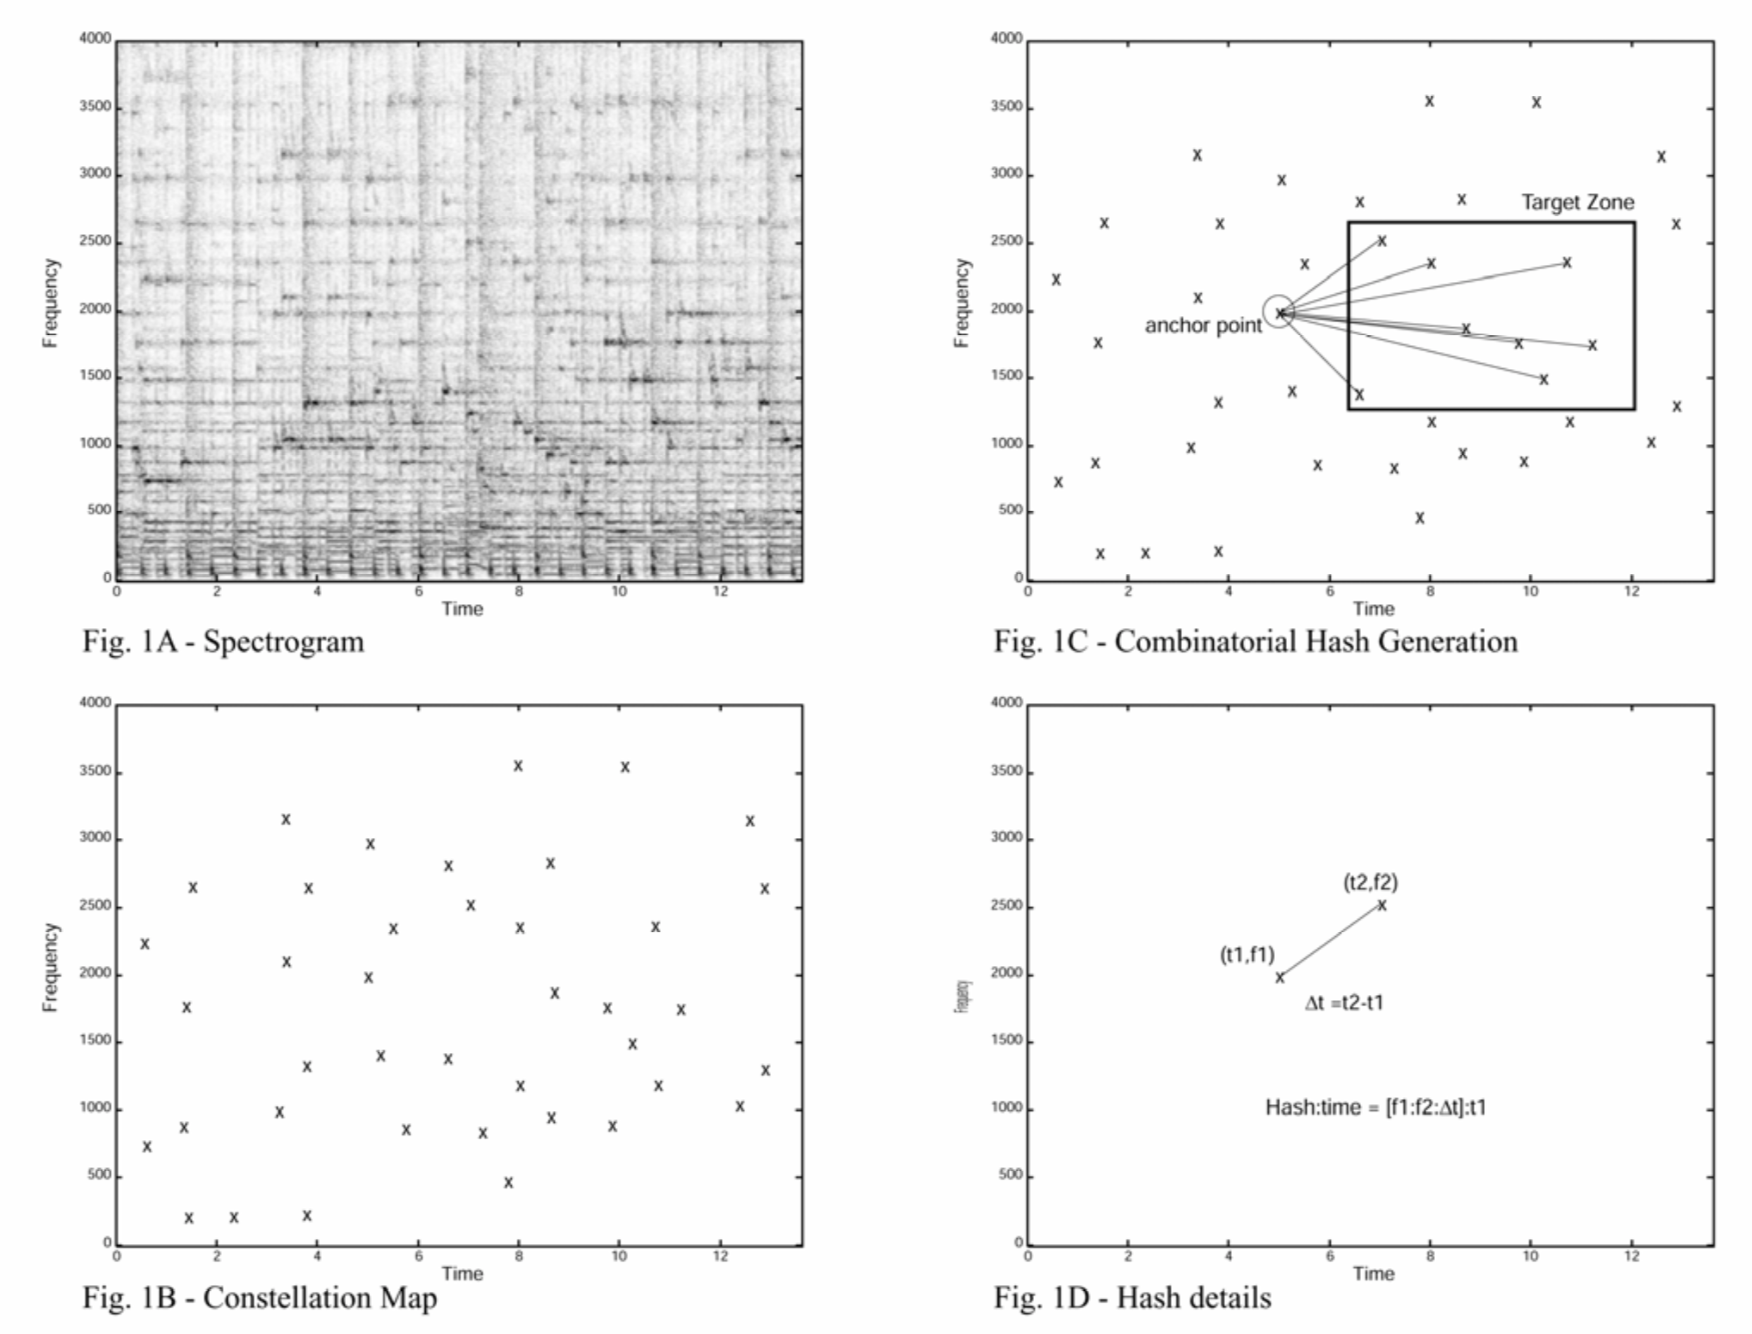

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [2]:
import librosa
import os, sys
from scipy import signal, fft
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

QUERIES = './queries/'
KIKIBOUBA = './KikiBoubadata/'

In [3]:
def mySTFT(samples, winlen, winhopsize, zeropad):
    freq, time, stft = signal.stft(samples,
                                   fs=Fs,
                                   window='hann',
                                   nfft=zeropad*Fs*winlen,
                                   nperseg=int(winlen*Fs),
                                   noverlap=(Fs*(winlen - winhopsize))
                                   )
    stft_dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return time, freq, stft_dB, stft

C:\Users\Grimmar\AppData\Local\Temp\ipykernel_16996\3311275781.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(time, freq/1000, stft_dB, cmap='Blues')


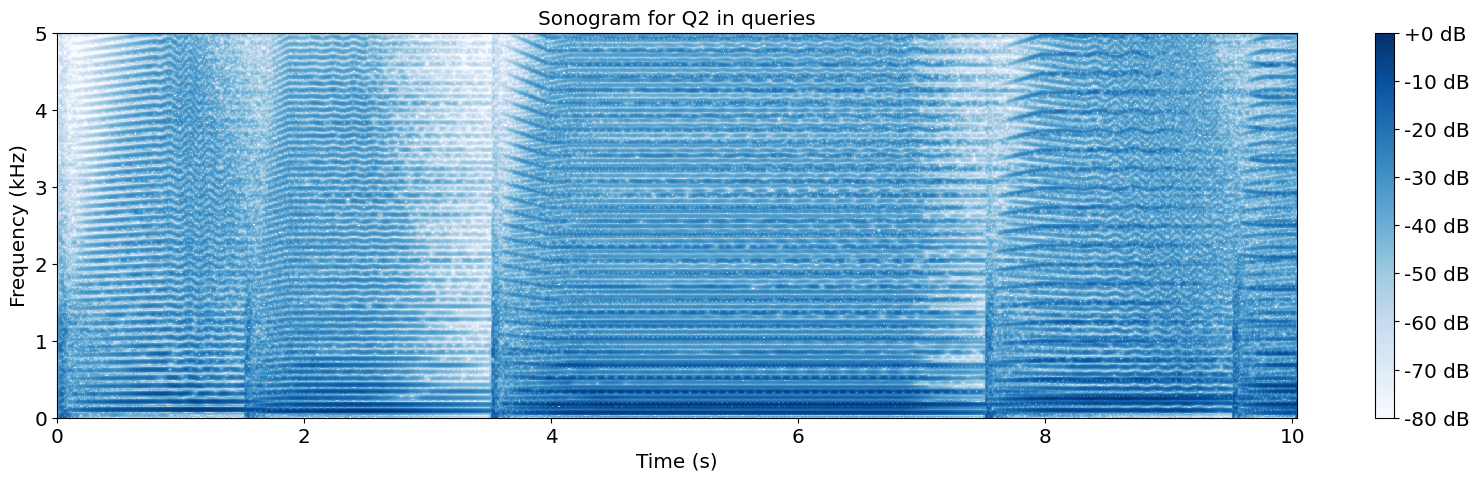

In [31]:
sound = pydub.AudioSegment.from_file(QUERIES + "Q2.wav", format="wav")
samples = sound.get_array_of_samples()
samples_norm = [(i/2**16)*2 for i in samples]

Fs = sound.frame_rate

if sound.channels > 1:
    channel_l = samples_norm[::2]
    channel_r = samples_norm[1::2]
    samples = channel_l

time, freq, stft_dB, stft = mySTFT(samples, 0.05, 0.01, 4)

plt.figure()
plt.title('Sonogram for Q2 in queries')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.ylim([0, 5])
plt.pcolormesh(time, freq/1000, stft_dB, cmap='Blues')
plt.colorbar(format='%+2.0f dB')
plt.show()

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [39]:
num_bands = 25
dT = 0.1
dF = (Fs / 2) / num_bands

num_time_seg = int(np.floor(time[-1] / dT)) 
anchors = np.empty((num_bands, num_time_seg))
anchors_idx = []

for f in range(num_bands):
    for t in range(num_time_seg):
        freqseg = (freq >= (f * dF)) & (freq < ((f + 1) * dF))
        timeseg = (time >= (t * dT)) & (time < ((t + 1) * dT))
        freqseg_idx = np.where(freqseg == True)[0]
        timeseg_idx = np.where(timeseg == True)[0]

        freqseg_l = freqseg_idx[0]
        freqseg_u = freqseg_idx[-1]
        timeseg_l = timeseg_idx[0]
        timeseg_u = timeseg_idx[-1]

        stft_seg = stft[freqseg_l:freqseg_u, timeseg_l:timeseg_u]
        anchors[f,t] = np.max(stft_seg)
        ravel_idx = np.argmax(stft_seg, axis=None)
        max_idx = np.unravel_index(ravel_idx, stft_seg.shape)
        freq_max_idx = freqseg_idx[max_idx[0]]
        time_max_idx = timeseg_idx[max_idx[1]]

        anchors_idx.append([freq[freq_max_idx], time[time_max_idx]])

anchors_idx = np.array(anchors_idx)

C:\Users\Grimmar\AppData\Local\Temp\ipykernel_16996\1797613962.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  anchors[f,t] = np.max(stft_seg)


3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

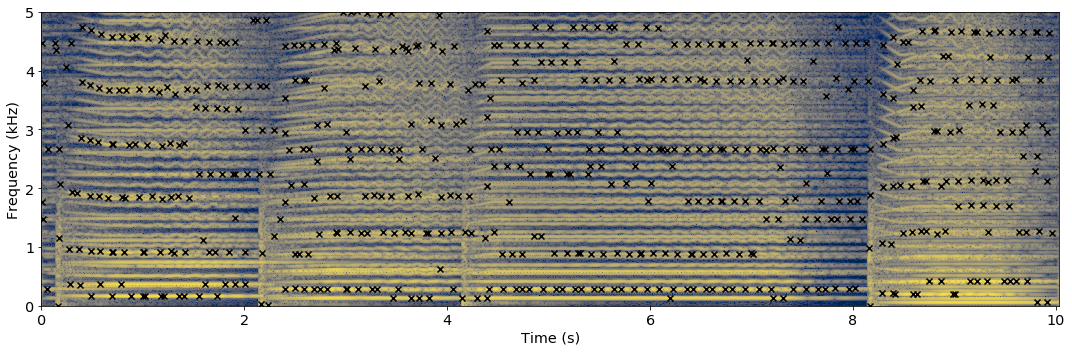

C:\Users\Grimmar\AppData\Local\Temp\ipykernel_16996\806767397.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(time, freq/1000, stft_dB, cmap='Blues')


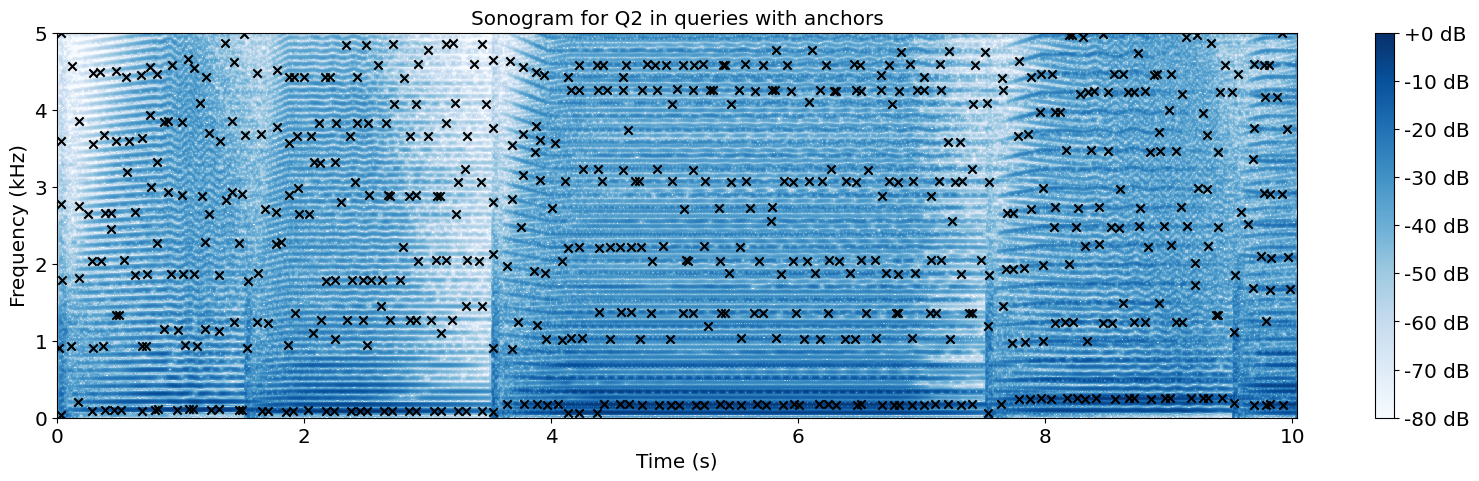

In [40]:
plt.figure()
plt.title('Sonogram for Q2 in queries with anchors')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.ylim([0, 5])
plt.pcolormesh(time, freq/1000, stft_dB, cmap='Blues')
plt.colorbar(format='%+2.0f dB')
plt.scatter(anchors_idx[:, 1], anchors_idx[:, 0] / 1000, marker='x', c='k')
plt.show()

The anchor point appears at the position with the largest energy in the sonogram, which corresponds to the local maximum within a small range of frequency and time. It can convert a complex sonogram into a sparse starbursts and significantly reduce the density of information.As the samples to be matched will also contain the same starbursts, the overlap of the starbursts will be particularly high when the samples are aligned with the correct position of the database songs. 

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [41]:
fp_q2 = []
for anchor in anchors_idx:
    f1, t1 = anchor[0], anchor[1]
    
    f_zone = [2**(-0.5), 2**(0.5)]
    t_zone = [0.1, 0.1 + 0.5]
    
    f_target = np.where((anchors_idx[:,0] >= (f1 * f_zone[0])) & (anchors_idx[:,0] < (f1 * f_zone[1])))[0]
    t_target = np.where((anchors_idx[:,1] >= (t1 + t_zone[0])) & (anchors_idx[:,1] < (t1 + t_zone[1])))[0]
    target = np.intersect1d(f_target, t_target)

    for a_t in anchors_idx[target]:
        f2, t2 = a_t[0], a_t[1]
        dt = t2 - t1
        hsh = (f1, f2, dt)
        fp_q2.append([t1, hsh])

fp_q2 = np.array(fp_q2, dtype=object)

print('Fingerprint time:', fp_q2[:, 0])
print('Fingerprint hashes:', fp_q2[:, 1])

Fingerprint time: [0.27999999999999997 0.27999999999999997 0.27999999999999997 ...
 9.879999999999999 9.879999999999999 9.879999999999999]
Fingerprint hashes: [(85.0, 95.0, 0.10999999999999999) (85.0, 100.0, 0.18)
 (85.0, 105.0, 0.24000000000000005) ...
 (21590.0, 15815.0, 0.10000000000000142)
 (21590.0, 16225.0, 0.10000000000000142)
 (21590.0, 18720.0, 0.10000000000000142)]


# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

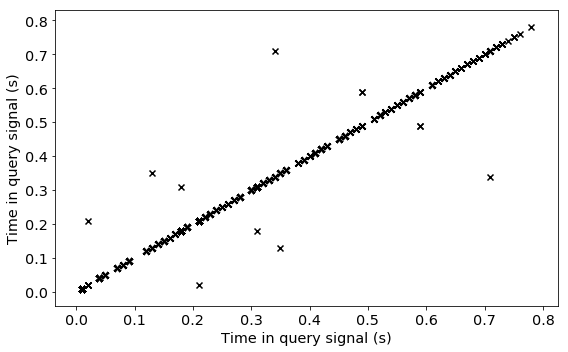



In [35]:
def comparefp(fp1, fp2):
    matches = []
    t_fp1, t_fp2 = fp1[:,0], fp2[:,0]
    hsh_fp1, hsh_fp2 = np.vstack(fp1[:, 1]), np.vstack(fp2[:, 1])
    
    for i, hsh in enumerate(hsh_fp1):
        diff = np.sum(np.abs(hsh - hsh_fp2), axis=1)
        match = np.where(diff == 0)[0]
        
        if len(match) > 0:
            for m in match:
                matches.append([t_fp1[i], t_fp2[m]])
    return np.array(matches)

C:\Users\Grimmar\AppData\Local\Temp\ipykernel_16996\1453072547.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  anchors[f,t] = np.max(stft_seg)


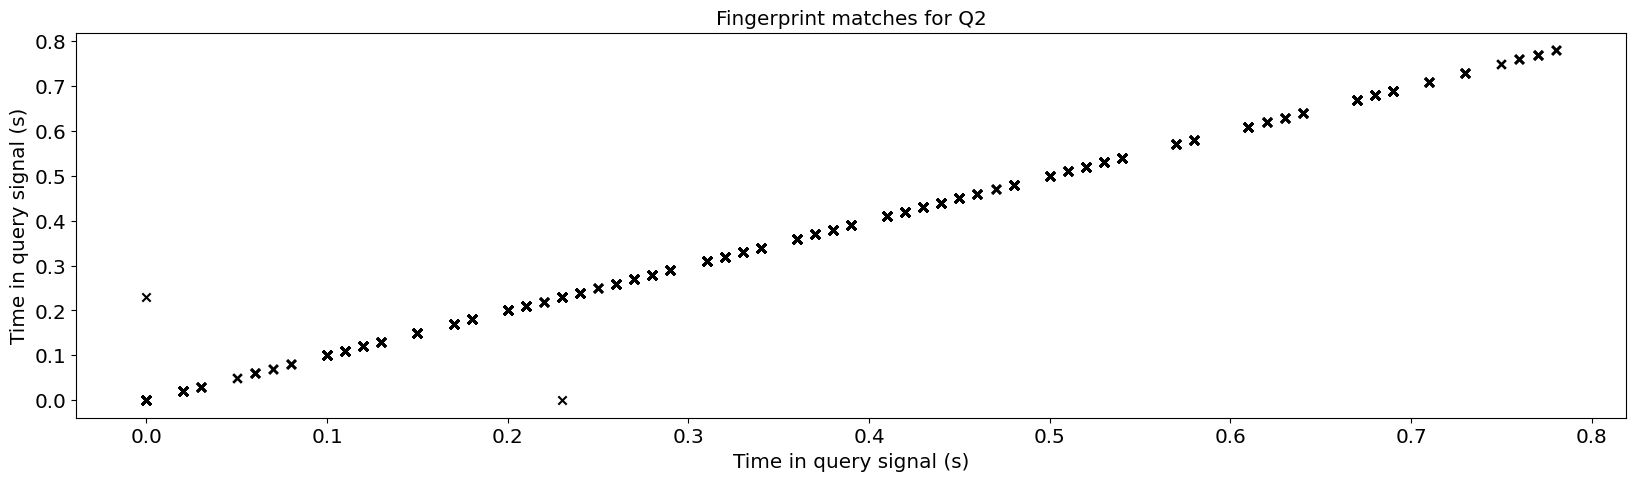

In [42]:
# segmentation
start_time = 3.0
start = int(np.ceil(start_time * Fs))
stop = int(np.ceil((start_time + 1.0) * Fs))
segment_time = np.linspace(start_time, start_time + 1.0, int(np.ceil(Fs * 1.0)))
segment = samples_norm[start:stop]

seg_time, seg_freq, seg_stft_dB, seg_stft = mySTFT(segment, 0.05, 0.01, 4)

# anchors
num_bands = 25
dT = 0.1
dF = (Fs / 2) / num_bands

num_time_seg = int(np.floor(seg_time[-1] / dT)) 
anchors = np.empty((num_bands, num_time_seg))
anchors_idx = []

for f in range(num_bands):
    for t in range(num_time_seg):
        freqseg = (seg_freq >= (f * dF)) & (seg_freq < ((f + 1) * dF))
        timeseg = (seg_time >= (t * dT)) & (seg_time < ((t + 1) * dT))
        freqseg_idx = np.where(freqseg == True)[0]
        timeseg_idx = np.where(timeseg == True)[0]

        freqseg_l = freqseg_idx[0]
        freqseg_u = freqseg_idx[-1]
        timeseg_l = timeseg_idx[0]
        timeseg_u = timeseg_idx[-1]

        stft_seg = seg_stft[freqseg_l:freqseg_u, timeseg_l:timeseg_u]
        anchors[f,t] = np.max(stft_seg)
        ravel_idx = np.argmax(stft_seg, axis=None)
        max_idx = np.unravel_index(ravel_idx, stft_seg.shape)
        freq_max_idx = freqseg_idx[max_idx[0]]
        time_max_idx = timeseg_idx[max_idx[1]]

        anchors_idx.append([freq[freq_max_idx], time[time_max_idx]])

anchors_idx = np.array(anchors_idx)

fp_seg_q2 = []
for anchor in anchors_idx:
    f1, t1 = anchor[0], anchor[1]
    
    f_zone = [2**(-0.5), 2**(0.5)]
    t_zone = [0.1, 0.1 + 0.5]
    
    f_target = np.where((anchors_idx[:,0] >= (f1 * f_zone[0])) & (anchors_idx[:,0] < (f1 * f_zone[1])))[0]
    t_target = np.where((anchors_idx[:,1] >= (t1 + t_zone[0])) & (anchors_idx[:,1] < (t1 + t_zone[1])))[0]
    target = np.intersect1d(f_target, t_target)

    for a_t in anchors_idx[target]:
        f2, t2 = a_t[0], a_t[1]
        dt = t2 - t1
        hsh = (f1, f2, dt)
        fp_seg_q2.append([t1, hsh])

fp_seg_q2 = np.array(fp_seg_q2, dtype=object)

matches = comparefp(fp_seg_q2, fp_seg_q2)

plt.figure()
plt.title('Fingerprint matches for Q2')
plt.ylabel('Time in query signal (s)')
plt.xlabel('Time in query signal (s)')
plt.scatter(matches[:, 0], matches[:, 1], marker='x', c='k')
plt.show()

The comparison shows that most of the points fall on the diagonal, indicating that the fingerprints extracted from the sample and those on the correct song match have the same relative time.This is because the absolute value of the difference of the hash is ideally 0 for all segments. However, we can also see some points in the graph that are shifted outside of this diagonal, due to hash similarity in other parts of the audio.

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

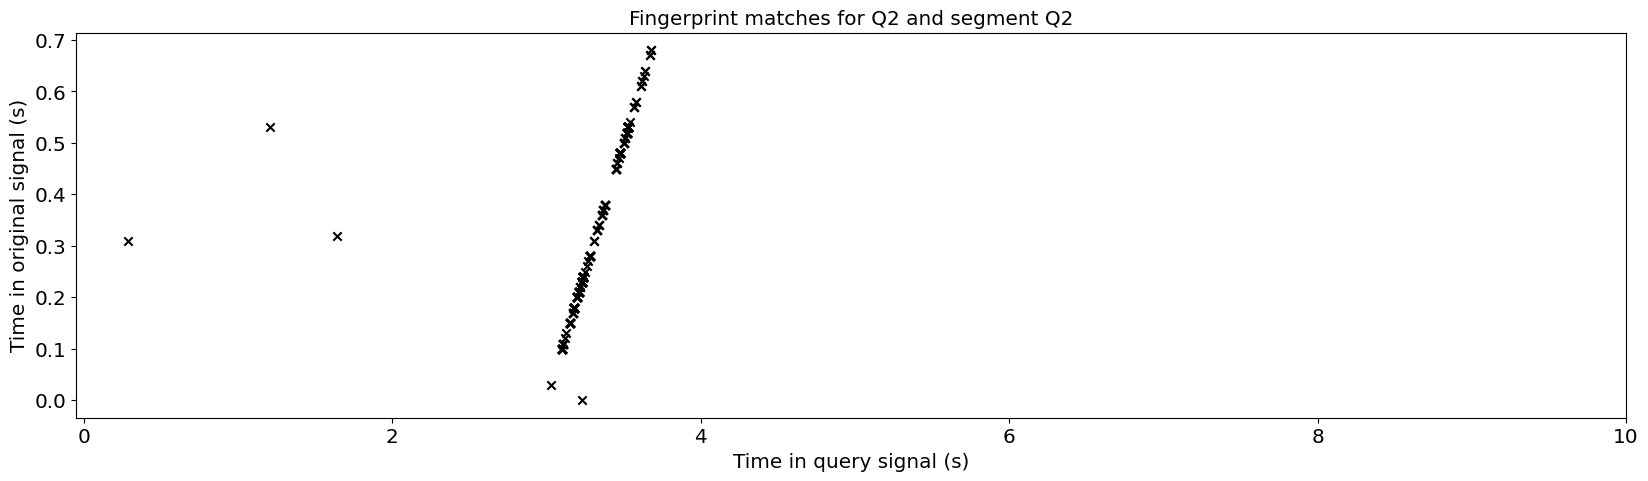

In [44]:
matches = comparefp(fp_q2, fp_seg_q2)
plt.figure()
plt.title('Fingerprint matches for Q2 and segment Q2')
plt.ylabel('Time in original signal (s)')
plt.xlabel('Time in query signal (s)')
plt.xlim((-0.05, 10))
plt.scatter(matches[:, 0], matches[:, 1], marker='x', c='k')
plt.show()

The comparison shows a clear match line as shown in 2.1 between 3s and 4s, indicating that the query audio clip matches this section of the database song exactly. There are also some outliers in the image, indicating that the points have the same hash but appear at different times which has been explained in 2.1.

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

C:\Users\Grimmar\AppData\Local\Temp\ipykernel_16996\1237493637.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  anchors[f,t] = np.max(stft_seg)


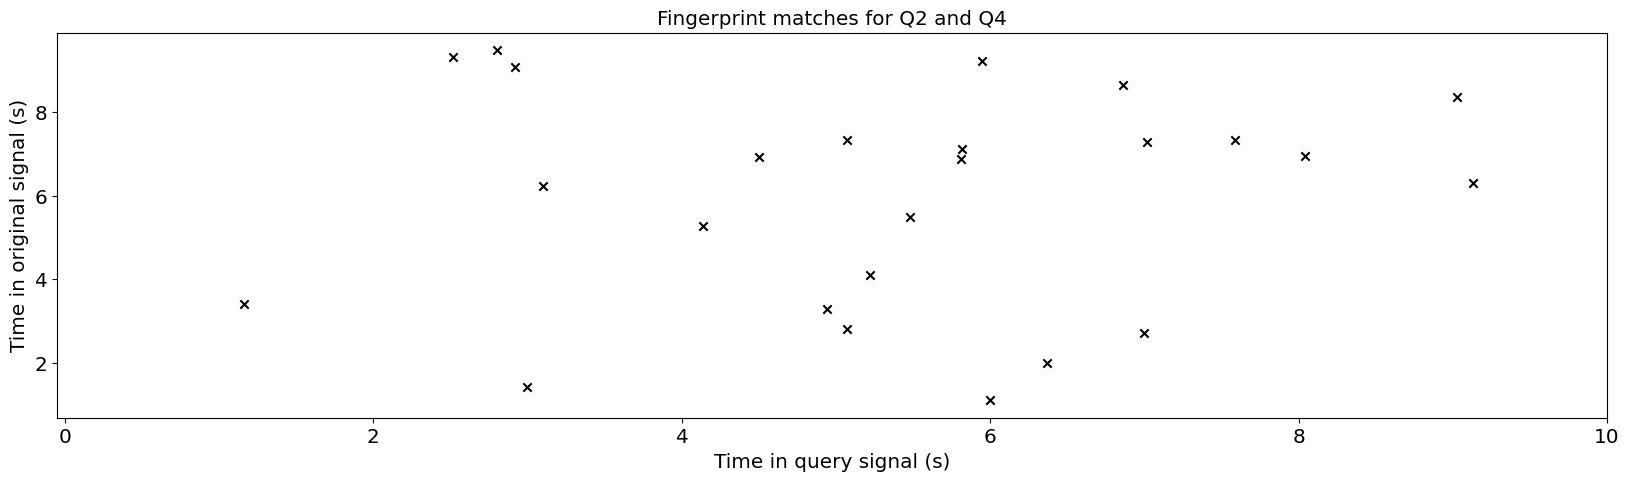

In [45]:
sound = pydub.AudioSegment.from_file(QUERIES + "Q4.wav", format="wav")
samples = sound.get_array_of_samples()
samples_norm = [(i/2**16)*2 for i in samples]

Fs = sound.frame_rate

if sound.channels > 1:
    channel_l = samples_norm[::2]
    channel_r = samples_norm[1::2]
    samples = channel_l

time, freq, stft_dB, stft = mySTFT(samples, 0.05, 0.01, 4)

num_bands = 25
dT = 0.1
dF = (Fs / 2) / num_bands

num_time_seg = int(np.floor(time[-1] / dT)) 
anchors = np.empty((num_bands, num_time_seg))
anchors_idx = []

for f in range(num_bands):
    for t in range(num_time_seg):
        freqseg = (freq >= (f * dF)) & (freq < ((f + 1) * dF))
        timeseg = (time >= (t * dT)) & (time < ((t + 1) * dT))
        freqseg_idx = np.where(freqseg == True)[0]
        timeseg_idx = np.where(timeseg == True)[0]

        freqseg_l = freqseg_idx[0]
        freqseg_u = freqseg_idx[-1]
        timeseg_l = timeseg_idx[0]
        timeseg_u = timeseg_idx[-1]

        stft_seg = stft[freqseg_l:freqseg_u, timeseg_l:timeseg_u]
        anchors[f,t] = np.max(stft_seg)
        ravel_idx = np.argmax(stft_seg, axis=None)
        max_idx = np.unravel_index(ravel_idx, stft_seg.shape)
        freq_max_idx = freqseg_idx[max_idx[0]]
        time_max_idx = timeseg_idx[max_idx[1]]

        anchors_idx.append([freq[freq_max_idx], time[time_max_idx]])

anchors_idx = np.array(anchors_idx)
fp_q4 = []
for anchor in anchors_idx:
    f1, t1 = anchor[0], anchor[1]
    
    f_zone = [2**(-0.5), 2**(0.5)]
    t_zone = [0.1, 0.1 + 0.5]
    
    f_target = np.where((anchors_idx[:,0] >= (f1 * f_zone[0])) & (anchors_idx[:,0] < (f1 * f_zone[1])))[0]
    t_target = np.where((anchors_idx[:,1] >= (t1 + t_zone[0])) & (anchors_idx[:,1] < (t1 + t_zone[1])))[0]
    target = np.intersect1d(f_target, t_target)

    for a_t in anchors_idx[target]:
        f2, t2 = a_t[0], a_t[1]
        dt = t2 - t1
        hsh = (f1, f2, dt)
        fp_q4.append([t1, hsh])

fp_q4 = np.array(fp_q4, dtype=object)

matches = comparefp(fp_q2, fp_q4)
plt.figure()
plt.title('Fingerprint matches for Q2 and Q4')
plt.ylabel('Time in original signal (s)')
plt.xlabel('Time in query signal (s)')
plt.xlim((-0.05, 10))
plt.scatter(matches[:, 0], matches[:, 1], marker='x', c='k')
plt.show()

The comparison shows that there are no matching lines in the graph, indicating that there are no segments in Q2 and Q4 that can be matched.Therefore, this music fingerprinting system is efficient in this case, because the human ear also hears Q2 and Q5 as two completely different pieces of music.

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.